In [1]:
import torch, os, random, cv2
import kornia as K
from PIL import Image
from io import BytesIO
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import fastprogress, zipfile, json

In [2]:
bin_model = '/home/ubuntu/models/model.pth'
bin_conf = '/home/ubuntu/models/config.json'
mul_model = '/home/ubuntu/models/seg/multi/model.pth'
mul_conf = '/home/ubuntu/models/seg/multi/config.json'

In [3]:
mul_root = '/mnt/data/seg/segm/images'
bin_root = '/mnt/data/seg/bin/images'

In [4]:
import os
import mimetypes
from pathlib import Path
from functools import partial

get_ext = lambda x: [i for i,j in mimetypes.types_map.items() if j.startswith(x)]

image_ext = get_ext('image')
video_ext = get_ext('video')
text_ext = get_ext('video')
audio_ext = get_ext('audio')

join_path = lambda x,y: Path(os.path.join(x, y))

def get_files(root, file_type=None, recursive=True):
    files = []
    if file_type: file_type = tuple(file_type)
    if not recursive:
        files.extend([join_path(root, i) for i in os.listdir(root) if str(i).lower().endswith(file_type)])
    else:
        for p, d, fs in os.walk(root):
            if file_type:
                files.extend([join_path(p, f) for f in fs if str(f).lower().endswith(file_type)])
            else:
                files.extend([join_path(p, f) for f in fs])
    return files

get_image_files = partial(get_files, file_type = image_ext)
get_video_files = partial(get_files, file_type = video_ext)
get_text_files = partial(get_files, file_type = text_ext)
get_audio_files = partial(get_files, file_type = audio_ext)

In [5]:
class SegmentationDataset(Dataset):
    def __init__(self, fs, img_sz):
        self.fs = fs
        self.img_sz = img_sz
        
    def __getitem__(self, idx):
        img = Image.open(self.fs[idx]).convert('RGB')
        name = self.fs[idx].stem
        w,h = img.size
        img = np.array(img.resize((self.img_sz, self.img_sz)))
        return torch.from_numpy(img).permute(2, 0, 1), torch.tensor([w,h]), name
    
    def __len__(self): return len(self.fs)

In [6]:
def save_img(data,name,sz,out):
    data = cv2.resize(data, dsize=sz.tolist(), interpolation=cv2.INTER_NEAREST)
    img = cv2.imencode('.png',(data*255).astype(np.uint8))[1]
    out.writestr(name+'.png', img)

In [7]:
class SegmentationPredict:
    def __init__(self, model_path, conf_path):
        self.load_conf(conf_path)
        self.model = self.load_model(model_path)
        self.img_sz = self.conf['img_sz']
        self.classes = self.conf['classes']
        self.bin = len(self.classes) == 2
        
    def load_model(self, o):
        m = torch.load(o)
        m = m.float()
        m = m.eval()
        return m
    
    def load_conf(self, p):
        with open(p, 'r') as f:
            self.conf = json.load(f)
    
    def single_predict(self, o):
        img = Image.open(o).convert('RGB')
        w,h = img.size
        img = np.array(img.resize((self.img_sz, self.img_sz)))
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).cuda().unsqueeze(0)
        img = self.normalize(img)
        with torch.no_grad():
            pred = self.model(img)
            if self.bin: pred = (pred.sigmoid() > 0.5).float().detach()
            else: pred = pred.softmax(axis=1).argmax(axis=1).detach()
        return self.encode_png(pred.squeeze().cpu().numpy(), h, w)
    
    def encode_png(self, o, h, w):
        o = cv2.resize(o, dsize=(h, w), interpolation=cv2.INTER_NEAREST)
        o = cv2.imencode('.png', o)[1]
        return o.tobytes()
        
    def normalize(self, o):
        return K.normalize(o/255.0,
                        mean=torch.tensor((0.485, 0.456, 0.406)),
                        std=torch.tensor((0.229, 0.224, 0.225)))
        
    def predict_dl(self, dl, exp_path):
        with zipfile.ZipFile(exp_path, 'a') as mask_out, torch.no_grad():
            for xb, yb, n in dl:
                pred = self.model(self.normalize(xb.cuda()))
                if self.bin: pred = (pred.sigmoid() > 0.5).float().detach()
                else: pred = pred.softmax(axis=1).argmax(axis=1).detach()
                pred = pred.squeeze().cpu().numpy()
                for mask, sz, name in zip(pred,yb,n):
                    save_img(mask.astype(np.uint8),name,sz,mask_out)
            
    def predict_folder(self, path):
        fs = get_image_files(path)
        ds = SegmentationDataset(fs, img_sz = self.img_sz)
        dl = DataLoader(ds, batch_size=16, num_workers=2, pin_memory=True)
        self.predict_dl(dl, 'masks.zip')
        return 'masks.zip'

In [8]:
bin_predict = SegmentationPredict(bin_model, bin_conf)

In [9]:
f = os.path.join(bin_root, random.choice(os.listdir(bin_root)))
o = bin_predict.single_predict(f)

/home/ubuntu/anaconda3/envs/torchdl0/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


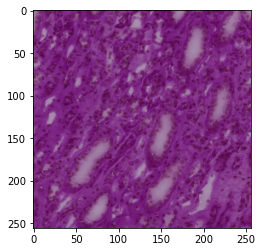

In [10]:
plt.imshow(cv2.imread(f))
plt.imshow(cv2.imdecode(np.array(bytearray(o), dtype=np.uint8), cv2.IMREAD_GRAYSCALE), alpha=0.3)

In [11]:
!rm masks.zip

rm: cannot remove 'masks.zip': No such file or directory


In [12]:
bin_predict.predict_folder(bin_root)

'masks.zip'

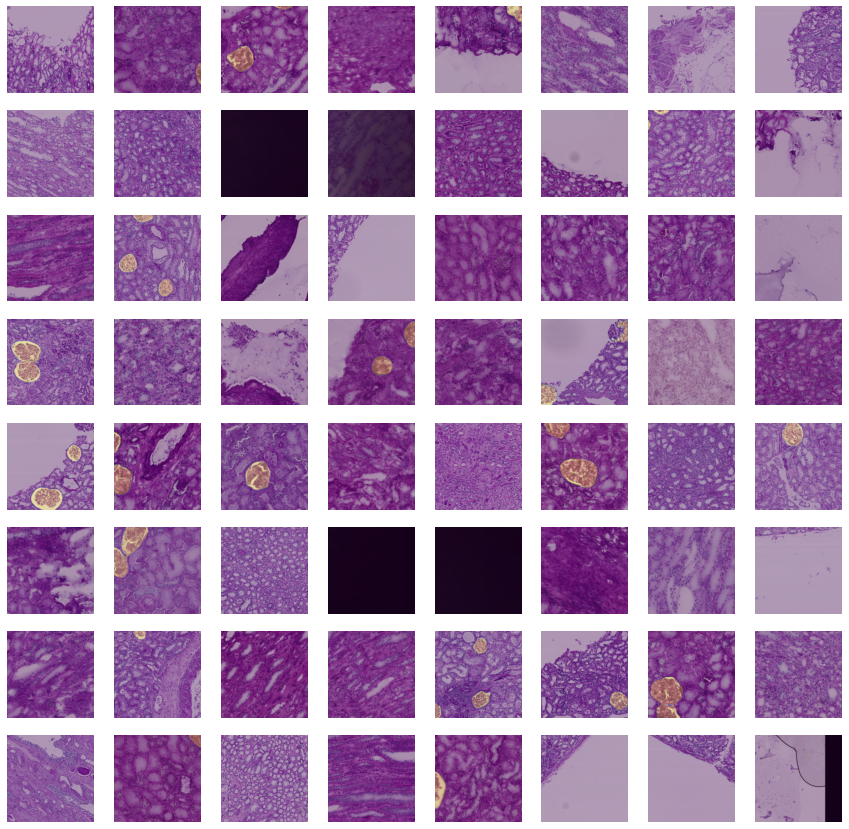

In [13]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
with zipfile.ZipFile('masks.zip') as mask_arch:
    fnames = sorted(mask_arch.namelist())[8:]
    for k, ax in enumerate(axes.ravel()):
        name = random.choice(fnames)
        img = Image.open(os.path.join(bin_root, name))
        mask = cv2.imdecode(np.frombuffer(mask_arch.read(name), np.uint8), cv2.IMREAD_GRAYSCALE)
        ax.imshow(img)
        ax.imshow(mask, alpha=0.3)
        ax.axis('off')

In [14]:
!rm masks.zip

In [15]:
mul_predict = SegmentationPredict(mul_model, mul_conf)

In [16]:
f = os.path.join(mul_root, random.choice(os.listdir(mul_root)))
o = mul_predict.single_predict(f)

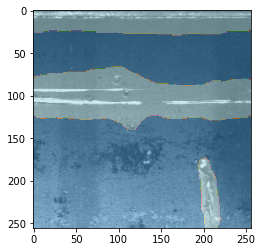

In [17]:
plt.imshow(cv2.imread(f))
plt.imshow(cv2.imdecode(np.array(bytearray(o), dtype=np.uint8), cv2.IMREAD_GRAYSCALE), alpha=0.5, cmap='tab20')

In [18]:
mul_predict.predict_folder(mul_root)

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


'masks.zip'

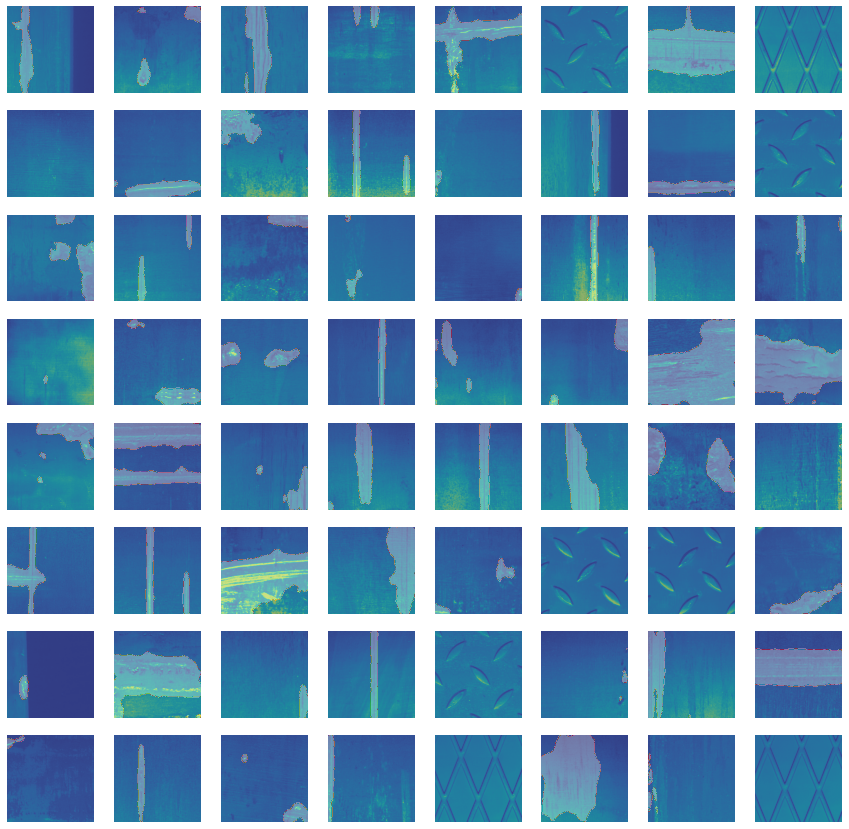

In [19]:
fig, axes = plt.subplots(8, 8, figsize=(15, 15))
with zipfile.ZipFile('masks.zip') as mask_arch:
    fnames = sorted(mask_arch.namelist())[8:]
    for k, ax in enumerate(axes.ravel()):
        name = random.choice(fnames)
        img = Image.open(os.path.join(mul_root, name)).convert('L')
        mask = cv2.imdecode(np.frombuffer(mask_arch.read(name), np.uint8), cv2.IMREAD_GRAYSCALE)
        ax.imshow(img)
        ax.imshow(mask, alpha=0.5, cmap='tab20')
        ax.axis('off')